<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP_V05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instala e importa as bibliotecas

In [1]:
!pip install tensorflow-text

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text

# Importando DataSet

In [3]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/20191226-reviews.csv"

# Lê o arquivo
df_mult = pd.read_csv(url, delimiter=',', encoding='latin-1')
df_bin = pd.read_csv(url, delimiter=',', encoding='latin-1')

df_bin.head(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


# Preparação do DATASET
Limpa o DataSet e separa um sobconjunto dos dados para utilização no trabalho, a redução do número de linhas tem por propósito acelerar o processo de treinamento e manipulação dos dados.

In [4]:
df_mult = df_mult.head(10000)
df_bin = df_bin.head(10000)

In [5]:
df_mult = df_mult.dropna()
df_mult = df_mult.reset_index(drop=True)

df_bin = df_bin.dropna()
df_bin = df_bin.reset_index(drop=True)

In [6]:
df_bin.head(10)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,the cell phone store owner,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
6,B0000SX2UC,Matt,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
7,B0000SX2UC,Charles Cook,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
8,B0000SX2UC,Amazon Customer,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0
9,B0000SX2UC,habblie,4,"December 25, 2004",False,"works great, but don't dropt it",I've had this phone for over a year and I real...,1.0


In [8]:
import re
df_bin["rating"] = df_bin["rating"].astype(int)
df_mult["rating"] = df_mult["rating"].astype(int)

In [9]:
#Para aumentar a acurácia e facilitar a tarefa de classificação, considerando a dificuldade em diferenciar classificações as classificações 1 e 2, assim como 4 e 5. Dessa forma
#resolvi converter 1 e 2 em "0" que significa uma avaliação negativa e 4 e 5 em "1" que significa uma classificação positiva, dessa forma vamos passar a abordar o problema como
#classificação binária.
mapping={1:0,2:0,3:None,4:1,5:1}
df_bin.rating=df_bin.rating.map(mapping)
df_bin=df_bin.dropna(subset='rating')

In [15]:
rat_bin=df_bin.rating.value_counts()
rat_mult=df_mult.rating.value_counts()

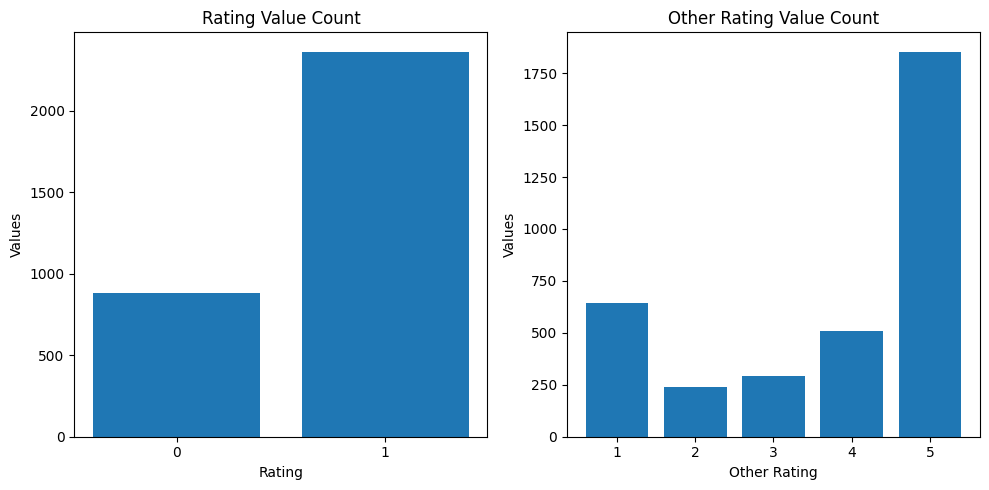

In [17]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_bin.index, rat_bin.values)
axes[0].set_xticks(rat_bin.index)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Values')
axes[0].set_title('Rating Value Count')

# Plotagem do segundo gráfico
axes[1].bar(rat_mult.index, rat_mult.values)
axes[1].set_xlabel('Other Rating')
axes[1].set_ylabel('Values')
axes[1].set_title('Other Rating Value Count')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()





In [41]:
df_bin.loc[:, "body"] = df_bin["body"].str.encode("ascii", "ignore").str.decode("utf-8")
df_bin.loc[:, "body"] = df_mult["body"].str.encode("ascii", "ignore").str.decode("utf-8")

In [42]:
df_bin = df_bin[["body", "rating"]]
df_mult = df_mult[["body", "rating"]]
df_mult.loc[:, 'rating'] = df_mult['rating'].astype(float)

In [13]:
df_mult.head(10)

,body,rating
0,I had the Samsung A600 for awhile which is abs...,3.0
1,Due to a software issue between Nokia and Spri...,1.0
2,"This is a great, reliable phone. I also purcha...",5.0
3,"I love the phone and all, because I really did...",3.0
4,The phone has been great for every purpose it ...,4.0
5,Cool. Cheap. Color: 3 words that describe the ...,5.0
6,"The 3599i is overall a nice phone, except that...",4.0
7,"I've never owned a Nokia phone before, so this...",5.0
8,ok well im in school and i need the text messa...,3.0
9,I've had this phone for over a year and I real...,4.0


# Separação em base de treino e teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_bin.body,df_bin.rating,test_size=0.2)
R_train, R_test, t_train, t_test = train_test_split(df_mult.body,df_mult.rating,test_size=0.2)

# Carrega o BERT preprocessor e encoder

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']
get_sentense_embeding([
    df_bin.body[5],df_bin.body[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.66974694, -0.55856156, -0.9775242 , ..., -0.939019  ,
        -0.6770846 ,  0.6674904 ],
       [-0.78146726, -0.6098954 , -0.9507825 , ..., -0.92656064,
        -0.7495821 ,  0.5948985 ]], dtype=float32)>

In [17]:
#1 neuronio de saída com ativação sigmoid
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
model_bin=tf.keras.Model(inputs=[text_input],outputs=[l])


#Alterado para considerar as 5 classses e ativação softmax
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model_mult=tf.keras.Model(inputs=[text_input],outputs=[l])

In [18]:
model_bin.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [19]:
METRICS_BIN=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_MULT=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_mult.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS_MULT)
model_bin.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS_BIN)

In [39]:
history = model_bin.fit(X_train,y_train,epochs=10)

Epoch 1/10
82/82 [==============================] - 25s 304ms/step - loss: 0.4227 - accuracy: 0.8131 - precision: 0.8124 - recall: 0.9655
Epoch 2/10
82/82 [==============================] - 25s 311ms/step - loss: 0.4194 - accuracy: 0.8100 - precision: 0.8104 - recall: 0.9639
Epoch 3/10
82/82 [==============================] - 26s 312ms/step - loss: 0.4155 - accuracy: 0.8112 - precision: 0.8157 - recall: 0.9559
Epoch 4/10
82/82 [==============================] - 26s 314ms/step - loss: 0.4139 - accuracy: 0.8204 - precision: 0.8301 - recall: 0.9464
Epoch 5/10
82/82 [==============================] - 26s 318ms/step - loss: 0.4050 - accuracy: 0.8162 - precision: 0.8223 - recall: 0.9528
Epoch 6/10
82/82 [==============================] - 26s 320ms/step - loss: 0.3975 - accuracy: 0.8235 - precision: 0.8332 - recall: 0.9464
Epoch 7/10
82/82 [==============================] - 26s 323ms/step - loss: 0.4041 - accuracy: 0.8177 - precision: 0.8250 - recall: 0.9506
Epoch 8/10
82/82 [================

In [44]:
#Converta os rótulos de classe em codificação one-hot
t_train_adjusted = t_train - 1
t_train_one_hot = tf.keras.utils.to_categorical(t_train_adjusted, num_classes=5)
#print(t_train_one_hot)

history_mult = model_mult.fit(R_train,t_train_one_hot,epochs=10)

Epoch 1/10
89/89 [==============================] - 27s 305ms/step - loss: 1.1037 - accuracy: 0.5979 - precision: 0.7236 - recall: 0.4406
Epoch 2/10
89/89 [==============================] - 27s 309ms/step - loss: 1.0842 - accuracy: 0.6054 - precision: 0.7388 - recall: 0.4622
Epoch 3/10
89/89 [==============================] - 28s 315ms/step - loss: 1.0928 - accuracy: 0.6124 - precision: 0.7232 - recall: 0.4646
Epoch 4/10
89/89 [==============================] - 28s 317ms/step - loss: 1.0780 - accuracy: 0.6071 - precision: 0.7372 - recall: 0.4632
Epoch 5/10
89/89 [==============================] - 28s 320ms/step - loss: 1.0737 - accuracy: 0.6089 - precision: 0.7345 - recall: 0.4707
Epoch 6/10
89/89 [==============================] - 29s 323ms/step - loss: 1.0650 - accuracy: 0.6170 - precision: 0.7410 - recall: 0.4745
Epoch 7/10
89/89 [==============================] - 29s 325ms/step - loss: 1.0710 - accuracy: 0.6075 - precision: 0.7292 - recall: 0.4629
Epoch 8/10
89/89 [================

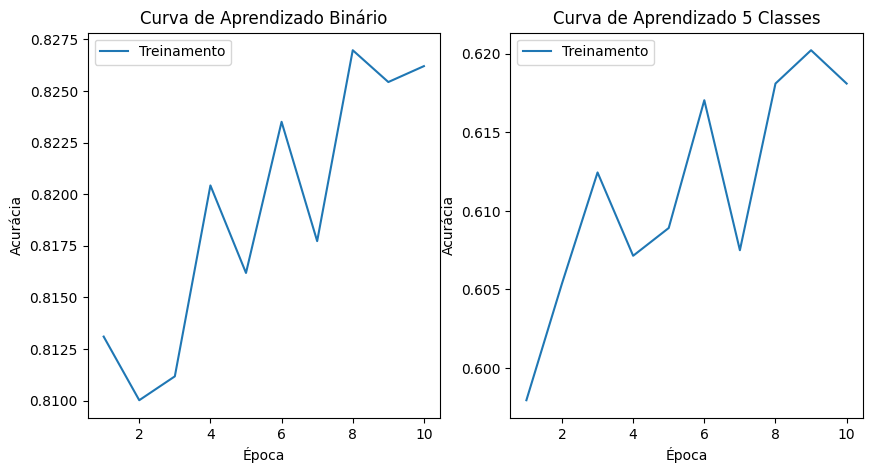

In [49]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Obtendo os scores de treinamento do histórico
train_scores_mult = history_mult.history['accuracy']
train_scores = history.history['accuracy']

# Plotando a curva de aprendizado
axes[0].plot(range(1, 11), train_scores, label='Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Aprendizado Binário')
axes[0].legend()


# Plotando a curva de aprendizado
axes[1].plot(range(1, 11), train_scores_mult, label='Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia')
axes[1].set_title('Curva de Aprendizado 5 Classes')
axes[1].legend()

plt.show()


In [22]:
model_bin.evaluate(X_test,y_test)

21/21 [==============================] - 8s 326ms/step - loss: 0.4114 - accuracy: 0.8505 - precision: 0.8593 - recall: 0.9542


[0.41137799620628357,
 0.8505392670631409,
 0.8592870831489563,
 0.9541666507720947]

In [23]:
#Converta os rótulos de classe em codificação one-hot
t_test_adjusted = t_test - 1
t_test_one_hot = tf.keras.utils.to_categorical(t_test_adjusted, num_classes=5)

model_mult.evaluate(R_test,t_test_one_hot)

23/23 [==============================] - 8s 322ms/step - loss: 1.1347 - accuracy: 0.5884 - precision: 0.7329 - recall: 0.4385


[1.134742021560669, 0.5884016752243042, 0.7328605055809021, 0.4384724199771881]

In [24]:
y_pred=model_bin.predict(X_test)
y_pred=y_pred.flatten()

21/21 [==============================] - 7s 328ms/step


In [25]:
t_pred=model_mult.predict(R_test)
#t_pred=y_pred.flatten()
print(t_pred)

23/23 [==============================] - 8s 332ms/step
[[0.04920727 0.02075072 0.02980723 0.17307265 0.7271621 ]
 [0.21009168 0.03526621 0.04005411 0.12103567 0.59355235]
 [0.32840446 0.08036429 0.12336469 0.13626078 0.33160576]
 ...
 [0.26967886 0.07323072 0.13375667 0.1941846  0.32914916]
 [0.14399666 0.06950793 0.07121625 0.23447305 0.4808061 ]
 [0.03788695 0.02487165 0.02948363 0.1440466  0.76371115]]


In [36]:
t_pred_classes = np.argmax(t_pred, axis=1)
#print(t_pred_classes)

In [27]:
y_pred=np.where(y_pred>0.5,1,0)
#y_pred

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
t_test = t_test - 1
cm_mult=confusion_matrix(t_test,t_pred_classes)

Text(50.722222222222214, 0.5, 'Truth')

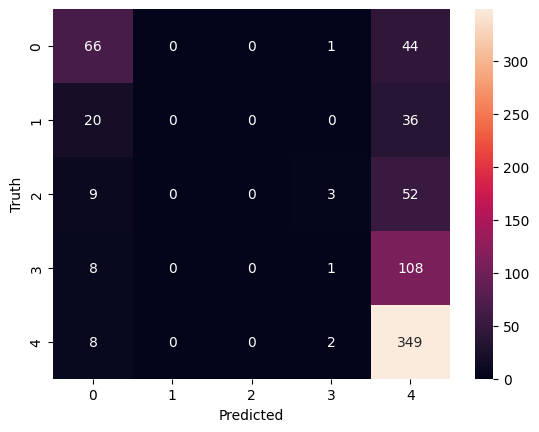

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm_mult,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [37]:
print(classification_report(t_test,t_pred_classes,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59       111
         1.0       1.00      0.00      0.00        56
         2.0       1.00      0.00      0.00        64
         3.0       0.14      0.01      0.02       117
         4.0       0.59      0.97      0.74       359

    accuracy                           0.59       707
   macro avg       0.67      0.32      0.27       707
weighted avg       0.59      0.59      0.47       707



Text(50.722222222222214, 0.5, 'Truth')

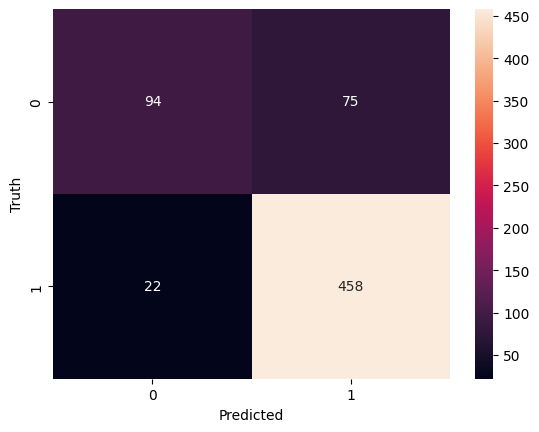

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.56      0.66       169
         1.0       0.86      0.95      0.90       480

    accuracy                           0.85       649
   macro avg       0.83      0.76      0.78       649
weighted avg       0.85      0.85      0.84       649



In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

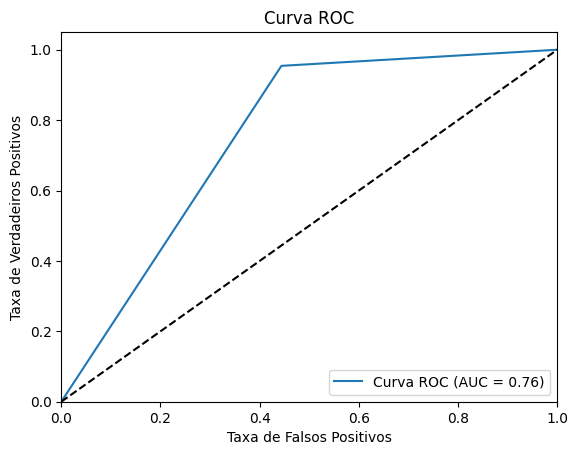

Área sob a curva (AUC): 0.7551898422090729


In [35]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir o valor da AUC
print('Área sob a curva (AUC):', roc_auc)